<a href="https://colab.research.google.com/github/BrianDL/fisica_computacional/blob/main/3%20-%20Modelo%20de%20Ising/ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np

def calcular_energia(red, H, J, beta):
    """
    Calcula la energía del sistema del modelo de Ising.

    Parámetros:
    red (np.array): Array 2D que representa la red de Ising
    H (float): Intensidad del campo magnético
    J (float): Fuerza de interacción
    beta (float): Temperatura inversa (1/T)

    Retorna:
    float: Energía total del sistema
    """
    L = red.shape[0]
    energia = 0
    magnetizacion = 0

    for i in range(L):
        for j in range(L):
            spin = red[i, j]
            vecinos = red[(i+1)%L, j] + red[i, (j+1)%L] + red[(i-1)%L, j] + red[i, (j-1)%L]

            energia += -J * spin * vecinos - H * spin
            magnetizacion += spin

    E = energia / 2  # Dividir por 2 para evitar contar dos veces
    M = magnetizacion / L**2

    return (E,M)

def calcular_magnetizacion(red):
    """
    Calcula la magnetización del sistema del modelo de Ising.

    Parámetros:
    red (np.array): Array 2D que representa la red de Ising

    Retorna:
    float: Magnetización total del sistema
    """
    L = red.shape[0]
    return np.sum(red)/L**2

### Probamos la funcionalidad
L = 10  # Tamaño de la red
H = 0.1  # Intensidad del campo magnético
J = 1.0  # Fuerza de interacción
beta = 0.4  # Temperatura inversa

# Crear una red inicial aleatoria
red_inicial = np.random.choice([-1, 1], size=(L, L))

# Calcular energía y magnetización iniciales
energia_inicial = calcular_energia(red_inicial, H, J, beta)
magnetizacion_inicial = calcular_magnetizacion(red_inicial)

print(f"Energía inicial: {energia_inicial}")
print(f"Magnetización inicial: {magnetizacion_inicial}")



Energía inicial: (24.099999999999994, -0.02)
Magnetización inicial: -0.02


In [64]:
def metropolis_ising(L, H, J, beta, N, inicializacion='caliente'):
    """
    Simula el modelo de Ising utilizando el algoritmo de Metropolis.

    Parámetros:
    L (int): Longitud de la red
    H (float): Intensidad del campo magnético
    J (float): Fuerza de interacción
    beta (float): Temperatura inversa (1/T)
    N (int): Número de pasos de Monte Carlo a realizar
    inicializacion (str): Tipo de inicialización ('frio' o 'caliente')

    Retorna:
    tuple: (energias, magnetizaciones, red_final)
    """
    ### Inicializar la red
    assert inicializacion in ('frio', 'caliente'), \
      "La inicialización debe ser en 'frio' o 'caliente' "

    red = np.ones((L, L)) if inicializacion == 'frio' else \
      np.random.choice([-1, 1], size=(L, L))  # Configuración aleatoria

    # energia, magnetizacion = calcular_energia(red, H, J, beta)

    ### Variables a devolver
    energias = []
    magnetizaciones = []

    t=0
    while t<N:
        # Calcular y almacenar la energía y magnetización al iniciar cada paso de Monte Carlo
        energia, magnetizacion = calcular_energia(red, H, J, beta)

        energias.append(energia)
        magnetizaciones.append(magnetizacion)


        for _ in range(L*L):  # Un paso de Monte Carlo es L*L intentos de flip
            # Seleccionar un sitio al azar
            i, j = np.random.randint(0, L, 2)

            # Calcular el cambio de energía si se invierte el spin
            vecinos = red[(i+1)%L, j] + red[i, (j+1)%L] + red[(i-1)%L, j] + red[i, (j-1)%L]
            delta_E = 2 * J * red[i, j] * vecinos + 2 * H * red[i, j]

            # Decidir si aceptar o rechazar el cambio
            aceptar = delta_E <= 0 \
              or np.random.random() < np.exp(-beta * delta_E)


            if not aceptar: continue
            red[i, j] *= -1

            # Calcular y almacenar la energía y magnetización para cada configuración aceptada
            # energia, magnetizacion = calcular_energia(red, H, J, beta)

            delta_M = 2*red[i,j]/L**2

            energia += delta_E
            magnetizacion += delta_M

            # magnetizacion = calcular_magnetizacion(red)
            energias.append(energia)
            magnetizaciones.append(magnetizacion)

        t+=1


    return energias, magnetizaciones, red


Una simulación con N=8192 toma 121.91997957229614 s.


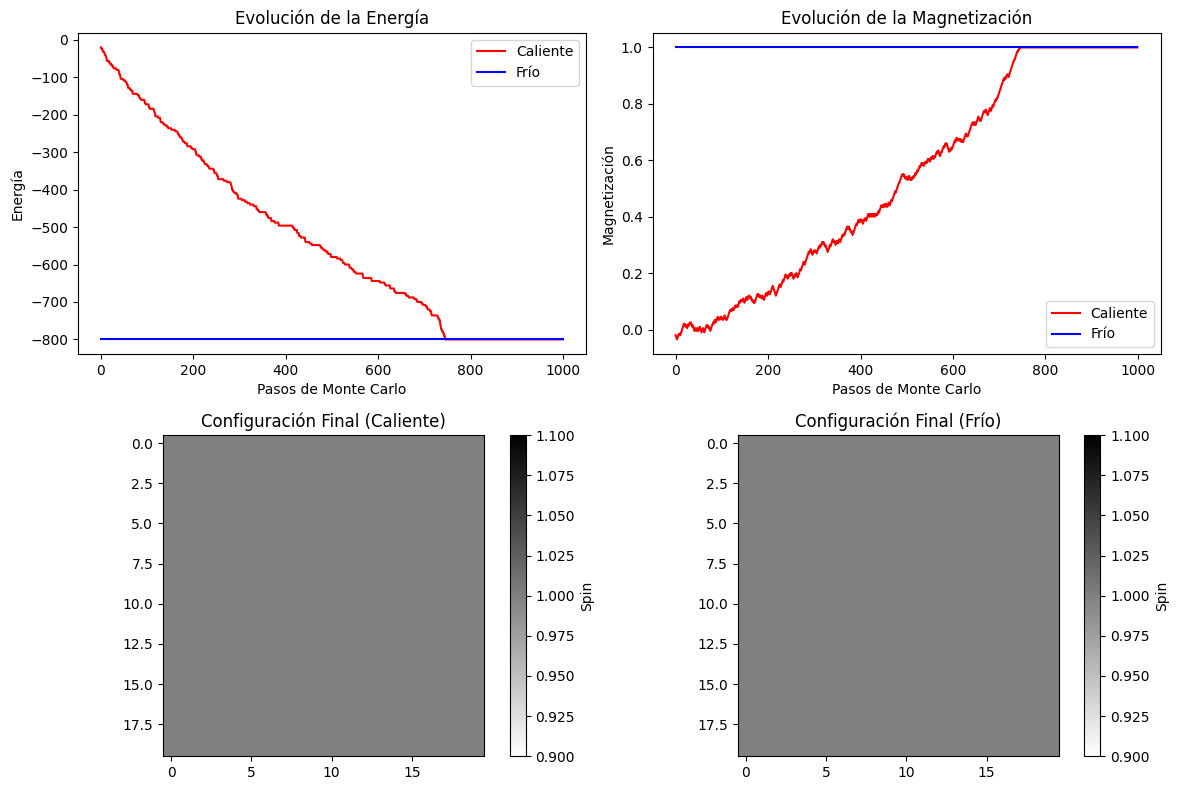

In [78]:
import time
L = 20  # Tamaño de la red
H = 0.0  # Intensidad del campo magnético
J = 1.0  # Fuerza de interacción
T = 0.1

beta = 1.0/T  # Temperatura inversa
N = 2**13  # Número de pasos de Monte Carlo


t0 = time.time()
# Simulación con inicialización caliente
energias_caliente, magnetizaciones_caliente, red_final_caliente = metropolis_ising(L, H, J, beta, N, 'caliente')
print(f"Una simulación con N={N} toma {time.time() - t0} s.")

# Simulación con inicialización fría
energias_frio, magnetizaciones_frio, red_final_frio = metropolis_ising(L, H, J, beta, N, 'frio')

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(energias_caliente[:1000], label='Caliente', color='r')
plt.plot(energias_frio[:1000], label='Frío', color='b')
plt.title("Evolución de la Energía")
plt.xlabel("Pasos de Monte Carlo")
plt.ylabel("Energía")
plt.legend()

plt.subplot(222)
plt.plot(magnetizaciones_caliente[:1000], label='Caliente', color='r')
plt.plot(magnetizaciones_frio[:1000], label='Frío', color='b')
plt.title("Evolución de la Magnetización")
plt.xlabel("Pasos de Monte Carlo")
plt.ylabel("Magnetización")
plt.legend()

plt.subplot(223)
plt.imshow(red_final_caliente, cmap='binary')
plt.title("Configuración Final (Caliente)")
plt.colorbar(label='Spin')

plt.subplot(224)
plt.imshow(red_final_frio, cmap='binary')
plt.title("Configuración Final (Frío)")
plt.colorbar(label='Spin')

plt.tight_layout()
plt.show()